In [ ]:
!pip install tensorflow==2.1.0
import tensorflow as tf
from tensorflow import keras 
tf.compat.v1.enable_eager_execution()
!pip install segmentation_models 
import segmentation_models as sm
from tensorflow.keras.utils import get_source_inputs
import segmentation_models as sm
from segmentation_models.metrics import iou_score
# loss
loss = sm.losses.cce_dice_loss
# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 421.8 MB 26 kB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
     |████████████████████████████████| 26.1 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 73.9 MB/s 
     |████████████████████████████████| 3.8 MB 59.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=9e49810351b0d7646819d0f1ff1db19e0c9f22329bdd4431e8e427c5243e3ec1
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import re

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/AAIC course/Assignment/29 UNET Segmentation/segmentation/data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [ ]:
def return_file_names_df(root_dir):
    dire = root_dir + '/images'
    image_path = []

    # write the code that will create a dataframe with two columns ['images', 'json']
    for fol in os.listdir(dire):
        sub_dire = os.path.join(dire, fol)
        for im in os.listdir(sub_dire):
            image_path.append(os.path.join(sub_dire, im))
    image_path = sorted(image_path)

    dire = root_dir + '/mask'
    mask_path = []

    for fol in os.listdir(dire):
        sub_dire = os.path.join(dire, fol)
        for im in os.listdir(sub_dire):
            mask_path.append(os.path.join(sub_dire, im))
    mask_path = sorted(mask_path)

    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    data_df = pd.DataFrame([image_path, mask_path]).T
    data_df = data_df.rename(columns= {0:'image', 1:'json'})
    
    return data_df

In [ ]:
data_df = return_file_names_df('/content/data')
data_df.head()

image  \
0  /content/data/images/201/frame0029_leftImg8bit...   
1  /content/data/images/201/frame0299_leftImg8bit...   
2  /content/data/images/201/frame0779_leftImg8bit...   
3  /content/data/images/201/frame1019_leftImg8bit...   
4  /content/data/images/201/frame1469_leftImg8bit...   

                                                json  
0  /content/data/mask/201/frame0029_gtFine_polygo...  
1  /content/data/mask/201/frame0299_gtFine_polygo...  
2  /content/data/mask/201/frame0779_gtFine_polygo...  
3  /content/data/mask/201/frame1019_gtFine_polygo...  
4  /content/data/mask/201/frame1469_gtFine_polygo...

> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

In [ ]:
cd /content

/content


In [ ]:
from tqdm import tqdm

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    final_labels = []
    for pat in tqdm(data_df.json):
        json_desti = pat
        with open(json_desti, 'rb') as openfile:
            json_object = json.load(openfile)
        ll = []
        for i in range(0,len(json_object['objects'])):
            ll.append(json_object['objects'][i]['label'])
        final_labels.extend(list(set(ll)))
    return set(final_labels)

In [ ]:
unique_labels = return_unique_labels(data_df)

100%|██████████| 4008/4008 [00:34<00:00, 114.61it/s]


<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before we pass it to the models, we need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    with open(file, 'rb') as openfile:
        json_file = json.load(openfile)
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    label, vertexlist = [], []

    for i in range(0, len(json_file['objects'])):
        label.append(json_file['objects'][i]['label'])
        that_poly = []
        for each_object in json_file['objects'][i]['polygon']:
            that_poly.append(tuple(each_object))
        vertexlist.append(that_poly)

    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    w = json_file['imgWidth']
    # height of the image
    h = json_file['imgHeight']
    return w, h, label, vertexlist

## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

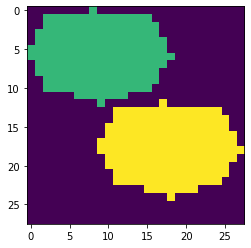

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

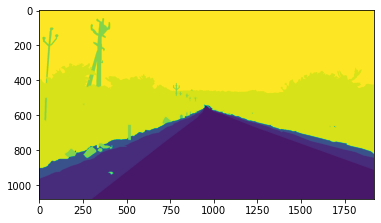

In [ ]:
# sample from dataset
w, h, label, vertexlist = get_poly(data_df.iloc[2681]["json"])
img = Image.new("RGB", (w,h))
img1 = ImageDraw.Draw(img)

img1 = ImageDraw.Draw(img)
for i in range(0, len(vertexlist)):
    if len(vertexlist[i]) > 1:
        img1.polygon(vertexlist[i], fill = label_clr[label[i]])

img=np.array(img)
plt.imshow(img[:,:,0])

In [ ]:
# creating folders for output mask images
os.mkdir('data/output/')
img_folder = os.listdir('data/images')
for i in img_folder:
    os.mkdir('data/output/{0}'.format(i))

In [ ]:
def compute_masks(data_df):
    mask_paths = []
    # after you have computed the vertexlist plot that polygone in image like this
    for i in tqdm(range(0, len(data_df))):
        w, h, label, vertexlist = get_poly(data_df.iloc[i]["json"])

        img = Image.new("RGB", (w, h))
        img1 = ImageDraw.Draw(img)
        for j in range(0, len(vertexlist)):
            if len(vertexlist[j]) > 1:
                img1.polygon(vertexlist[j], fill = label_clr[label[j]])

        # after drawing all the polygons that we collected from json file, 
        # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
        
        # after saving the image into disk, store the path in a list
        # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
        im_path_re = re.sub('mask', 'output', data_df.iloc[i]['json'])
        im_path_final = re.sub('json', 'png', im_path_re)
        mask_paths.append(im_path_final)
        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        im.save(im_path_final)

    data_df['mask'] = mask_paths
    return data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [04:19<00:00, 15.42it/s]


image  \
0  /content/data/images/201/frame0029_leftImg8bit...   
1  /content/data/images/201/frame0299_leftImg8bit...   
2  /content/data/images/201/frame0779_leftImg8bit...   
3  /content/data/images/201/frame1019_leftImg8bit...   
4  /content/data/images/201/frame1469_leftImg8bit...   

                                                json  \
0  /content/data/mask/201/frame0029_gtFine_polygo...   
1  /content/data/mask/201/frame0299_gtFine_polygo...   
2  /content/data/mask/201/frame0779_gtFine_polygo...   
3  /content/data/mask/201/frame1019_gtFine_polygo...   
4  /content/data/mask/201/frame1469_gtFine_polygo...   

                                                mask  
0  /content/data/output/201/frame0029_gtFine_poly...  
1  /content/data/output/201/frame0299_gtFine_poly...  
2  /content/data/output/201/frame0779_gtFine_poly...  
3  /content/data/output/201/frame1019_gtFine_poly...  
4  /content/data/output/201/frame1469_gtFine_poly...

In [ ]:
#daving the final dataframe to a csv file
data_df.to_csv('preprocessed_data.csv', index=False)

In [ ]:
data_df['image'] = data_df['image'].astype('string')
data_df['mask'] = data_df['mask'].astype('string')

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4008 entries, 0 to 4007
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   4008 non-null   string
 1   json    4008 non-null   object
 2   mask    4008 non-null   string
dtypes: object(1), string(2)
memory usage: 94.1+ KB


# Task 2: Applying Unet to segment the images

<pre>
* research paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

</pre>

### Task 2.1: Dice loss

<h2> Dice coefficient (DSC) </h2>

![Dice coefficient (DSC) ](https://miro.medium.com/max/720/1*oK8npb1wtF-GKeHi7yIBoQ.png)

Dice coefficient (DSC) is a measure of overlap between two sets. For example, if two sets A and B overlap perfectly, DSC gets its maximum value to 1. Otherwise, DSC starts to decrease, getting to its minimum value to 0 if the two sets don ‘t overlap at all. Therefore, the range of DSC is between 0 and 1, the larger the better. Thus we can use 1-DSC as Dice loss to maximize the overlap between two sets.



### Task 2.2: Training Unet

In [ ]:
# splitting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_df['image'], data_df['mask'], test_size=0.2, random_state=42)

In [ ]:
def normalize_image(mask):
    mask = mask/255
    return mask

In [ ]:
import imgaug.augmenters as iaa
# for image augmentations
aug2 = iaa.Fliplr(0.3)
aug3 = iaa.Flipud(0.3)
aug4 = iaa.Emboss(alpha=(0.0, 0.3), strength=(0.3, 0.6))
aug5 = iaa.DirectedEdgeDetect(alpha=(0.3), direction=(0.5))

In [ ]:
class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = list(set(label_clr.values()))
    
    def __init__(self, images_path, mask_path, training=True, width=256, height=256):

        self.og_img = images_path.values
        self.mask_img = mask_path.values
        self.classes = list(set(label_clr.values()))
        self.training = training
        self.width = width
        self.height = height

    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.og_img[i], cv2.IMREAD_UNCHANGED)
        mask  = cv2.imread(self.mask_img[i], cv2.IMREAD_UNCHANGED)
        image_mask = mask
        image = normalize_image(image)

        # resize image
        image = cv2.resize(image, (self.width, self.height), interpolation=cv2.INTER_NEAREST)
        image_mask = cv2.resize(image_mask, (self.width, self.height), interpolation=cv2.INTER_NEAREST)

        #onehotencoding 
        image_mask = [(image_mask == v) for v in self.classes]
        image_mask = np.stack(image_mask, axis=-1).astype('float')

        # while testing the model to avoid argumented image we put training if else.
        if self.training == True:
            a = np.random.uniform()
            if a<0.2:
                image = aug2.augment_image(image)
                image_mask = aug2.augment_image(image_mask)
            elif a<0.4:
                image = aug3.augment_image(image)
                image_mask = aug3.augment_image(image_mask)
            elif a<0.6:
                image = aug4.augment_image(image)
                image_mask = aug4.augment_image(image_mask)
            else:
                image = aug5.augment_image(image)
                image_mask = aug5.augment_image(image_mask)
                
            return image, image_mask
        else:
            return image, image_mask
        
    def __len__(self):
        return len(self.og_img)

In [ ]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_data = Dataset(X_train, y_train)
val_data = Dataset(X_test, y_test)

batch_size = 10
train_dataloader = Dataloder(train_data, batch_size)
val_dataloader = Dataloder(val_data, batch_size)

In [ ]:
len(train_dataloader)

320

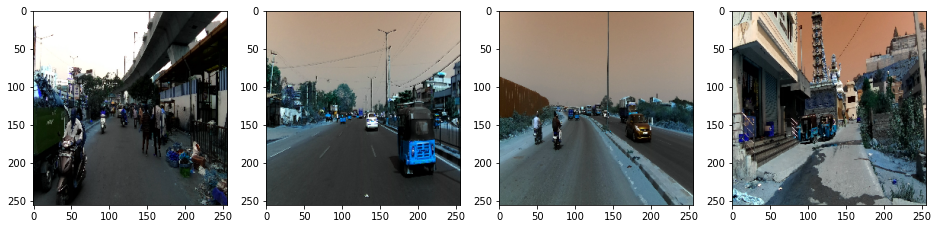

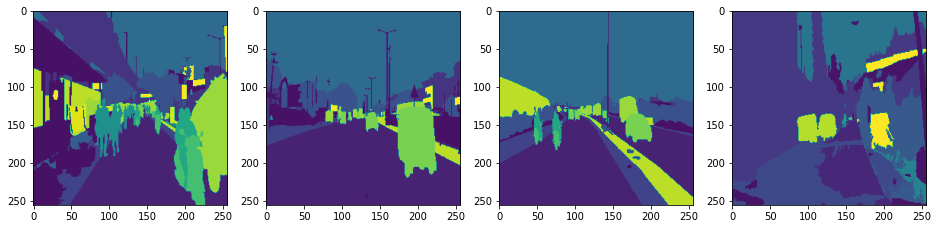

In [ ]:
# visualize some images from train dataloader and their masks
train_images, mask_images = train_dataloader[10]
plt.figure(figsize=(16, 5))
plt.title("Train Images")
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(train_images[i])
plt.figure(figsize=(16, 5))
plt.title("Train Masks")
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(np.argmax(mask_images[i], axis=-1))

# install

In [ ]:
import tensorflow as tf
import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
from segmentation_models.metrics import iou_score
# loss
loss = sm.losses.cce_dice_loss
# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [ ]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
unet_model = Unet('resnet34', encoder_weights='imagenet', classes=21, \
                  activation='softmax', input_shape=(256, 256, 3), encoder_freeze = True)

85524480/85521592 [==============================] - 9s 0us/step


In [ ]:
unet_model.summary()

Model: "u-resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_35 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_35[0][0]          
_________________________________________________________________________________________

In [ ]:
from tensorflow import keras 
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
%load_ext tensorboard
# directory to save log
log_dir='/content/logs/fit/model1/'
# call back of tensorboard
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

earlystop = EarlyStopping(monitor='val_iou_score',verbose=1, patience=3, mode='max')

In [ ]:
# model compile
unet_model.compile(optimizer, loss, metrics = [iou_score])

#defining the callbacks
callback = [tensorboard_callback, earlystop]

In [ ]:
history = unet_model.fit(train_dataloader, validation_data=val_dataloader, epochs=20, callbacks=callback)

Epoch 1/20
320/320 [==============================] - 341s 1s/step - loss: 1.9154 - iou_score: 0.1314 - val_loss: 3.1312 - val_iou_score: 0.2165
Epoch 2/20
320/320 [==============================] - 321s 1s/step - loss: 1.5608 - iou_score: 0.3235 - val_loss: 2.5661 - val_iou_score: 0.2735
Epoch 3/20
320/320 [==============================] - 320s 1s/step - loss: 1.5235 - iou_score: 0.3378 - val_loss: 1.7204 - val_iou_score: 0.3330
Epoch 4/20
320/320 [==============================] - 322s 1s/step - loss: 1.4253 - iou_score: 0.3679 - val_loss: 1.1696 - val_iou_score: 0.3681
Epoch 5/20
320/320 [==============================] - 321s 1s/step - loss: 1.4221 - iou_score: 0.3757 - val_loss: 1.4211 - val_iou_score: 0.3845
Epoch 6/20
320/320 [==============================] - 323s 1s/step - loss: 1.3580 - iou_score: 0.3857 - val_loss: 1.0633 - val_iou_score: 0.3886
Epoch 7/20
320/320 [==============================] - 321s 1s/step - loss: 1.3555 - iou_score: 0.3920 - val_loss: 0.9356 - val_iou

In [ ]:
history = unet_model.fit(train_dataloader, validation_data=val_dataloader, epochs=10, callbacks=callback)

Epoch 1/10
  2/320 [..............................] - ETA: 10:30 - loss: 1.4772 - iou_score: 0.4351

/usr/local/lib/python3.7/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.528385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


320/320 [==============================] - 329s 1s/step - loss: 1.2286 - iou_score: 0.4526 - val_loss: 1.1907 - val_iou_score: 0.4455
Epoch 2/10
320/320 [==============================] - 319s 996ms/step - loss: 1.2177 - iou_score: 0.4551 - val_loss: 1.0511 - val_iou_score: 0.4522
Epoch 3/10
320/320 [==============================] - 318s 993ms/step - loss: 1.2150 - iou_score: 0.4582 - val_loss: 1.6874 - val_iou_score: 0.4494
Epoch 4/10
320/320 [==============================] - 324s 1s/step - loss: 1.1965 - iou_score: 0.4604 - val_loss: 1.4106 - val_iou_score: 0.4625
Epoch 5/10
320/320 [==============================] - 322s 1s/step - loss: 1.2113 - iou_score: 0.4596 - val_loss: 1.4179 - val_iou_score: 0.4405
Epoch 6/10
320/320 [==============================] - 324s 1s/step - loss: 1.1869 - iou_score: 0.4629 - val_loss: 1.4136 - val_iou_score: 0.4736
Epoch 7/10
320/320 [==============================] - 357s 1s/step - loss: 1.1468 - iou_score: 0.4714 - val_loss: 1.5353 - val_iou_scor

In [ ]:
history = unet_model.fit(train_dataloader, validation_data=val_dataloader, epochs=10, callbacks=callback)

Epoch 1/10
320/320 [==============================] - 340s 1s/step - loss: 1.1721 - iou_score: 0.4698 - val_loss: 0.9413 - val_iou_score: 0.4599
Epoch 2/10
320/320 [==============================] - 321s 1s/step - loss: 1.1633 - iou_score: 0.4715 - val_loss: 1.4907 - val_iou_score: 0.4616
Epoch 3/10
320/320 [==============================] - 319s 997ms/step - loss: 1.1656 - iou_score: 0.4725 - val_loss: 1.4644 - val_iou_score: 0.4656
Epoch 4/10
320/320 [==============================] - 321s 1s/step - loss: 1.1535 - iou_score: 0.4752 - val_loss: 1.2389 - val_iou_score: 0.4553
Epoch 5/10
320/320 [==============================] - 321s 1s/step - loss: 1.1485 - iou_score: 0.4763 - val_loss: 1.0662 - val_iou_score: 0.4612
Epoch 6/10
320/320 [==============================] - 323s 1s/step - loss: 1.1157 - iou_score: 0.4832 - val_loss: 1.1764 - val_iou_score: 0.4741
Epoch 7/10
320/320 [==============================] - 319s 997ms/step - loss: 1.1300 - iou_score: 0.4835 - val_loss: 1.2824 - v

In [ ]:
%tensorboard --logdir /content/logs/fit/model1

<IPython.core.display.Javascript object>

In [ ]:
unet_model.save('unet_model_0.48.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [ ]:
from google.colab import files
files.download('unet_model_0.48.h5') 

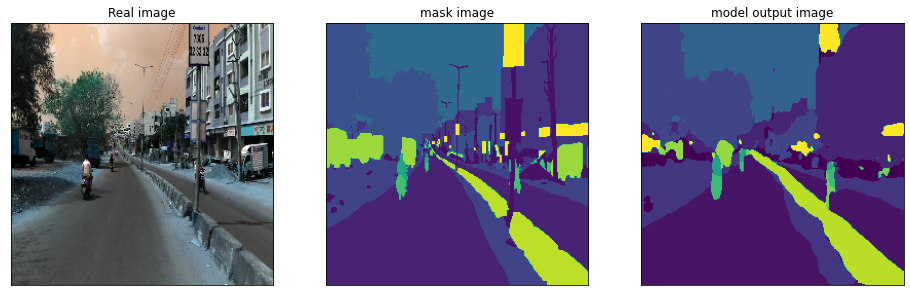

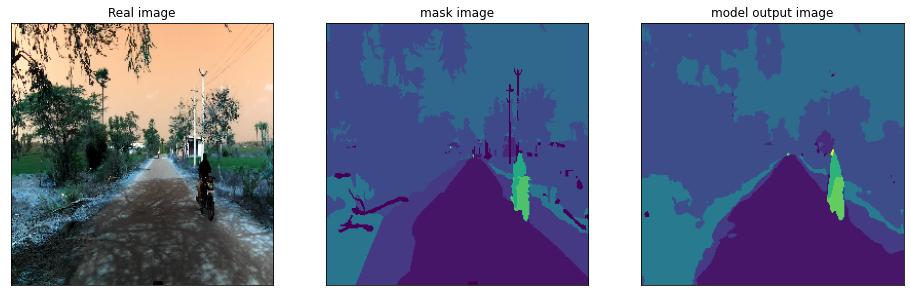

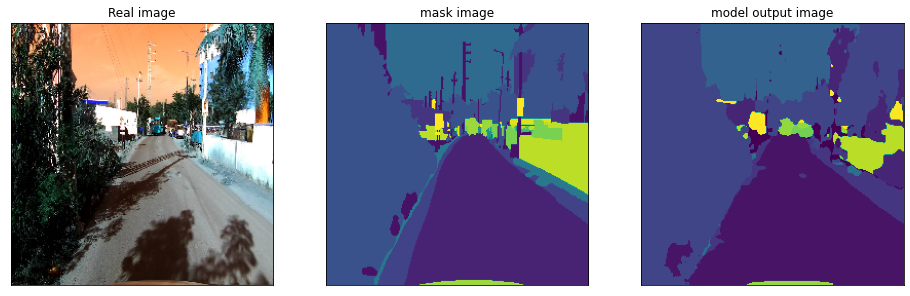

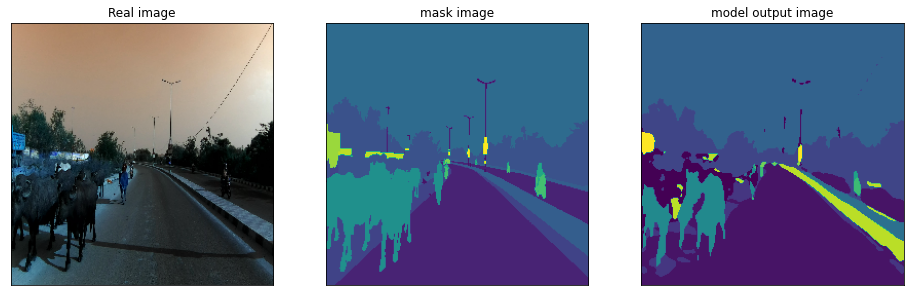

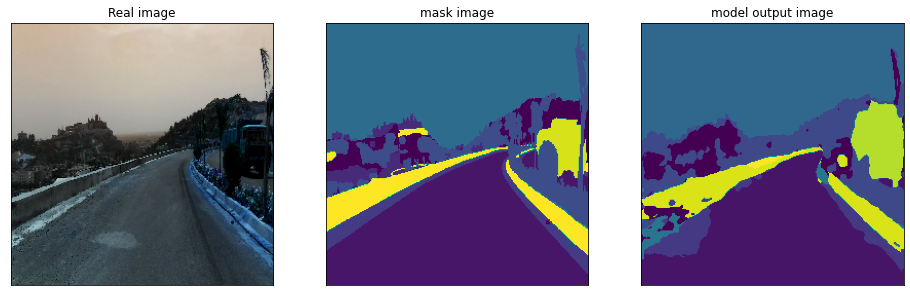

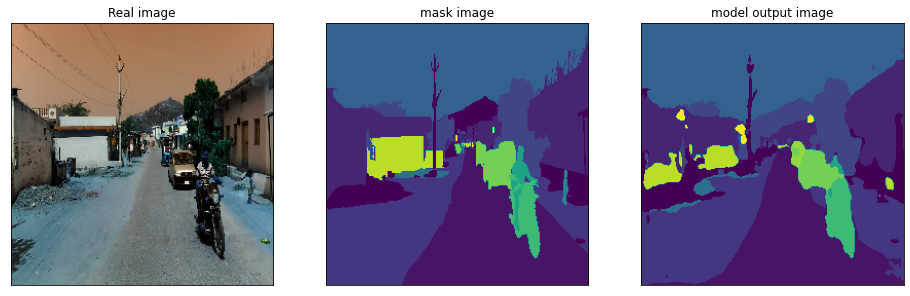

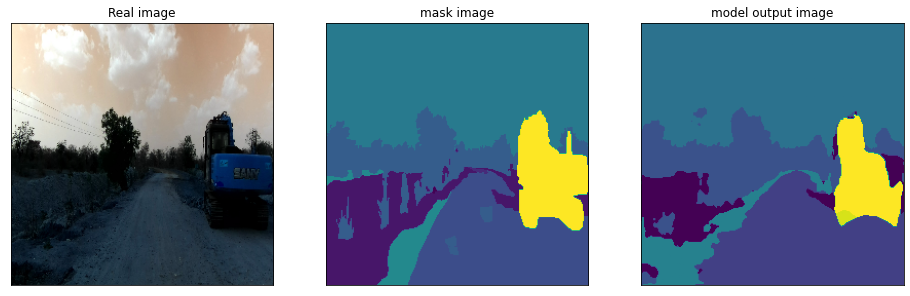

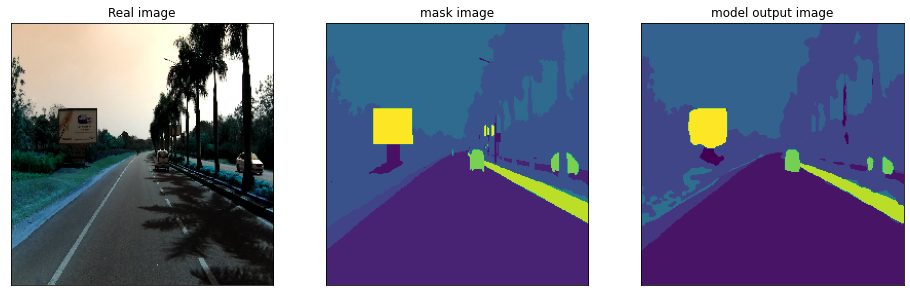

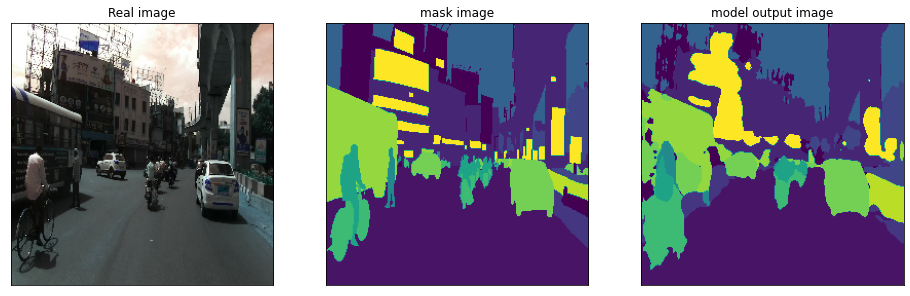

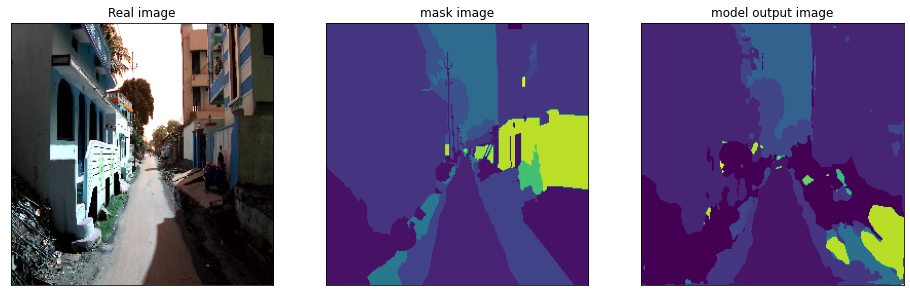

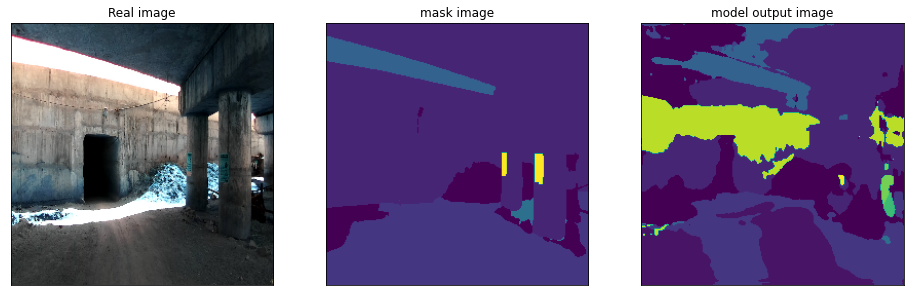

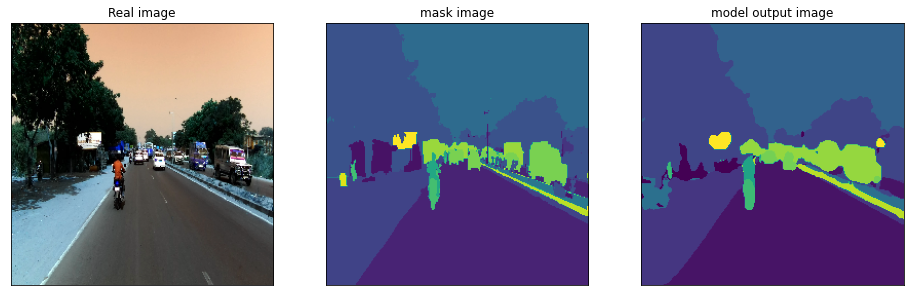

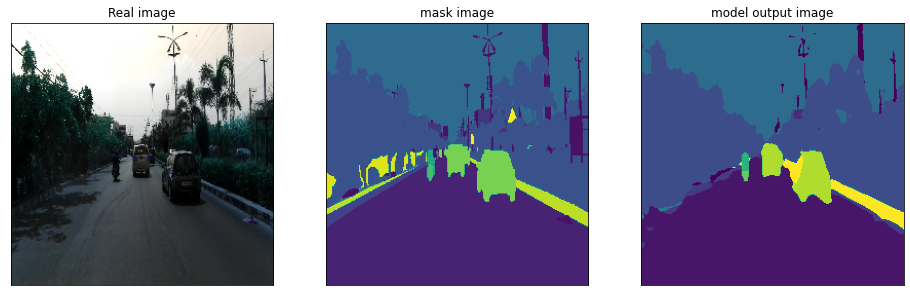

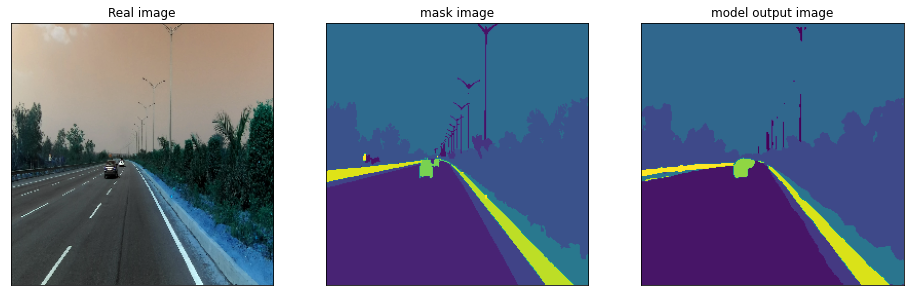

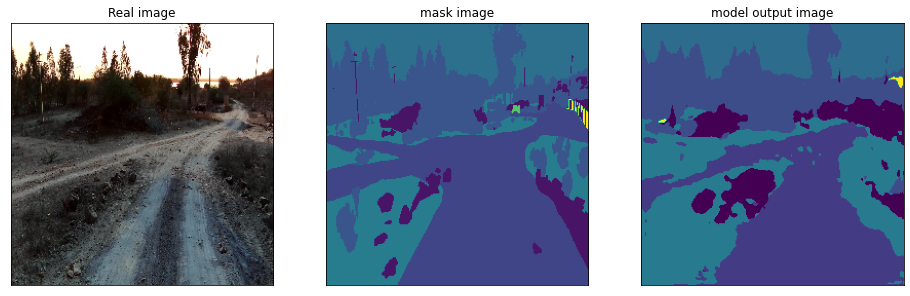

In [ ]:
n = 15
for i in range(n):
    plt.figure(figsize=(16, 5))
    og_image, mask_image = Dataset(X_test.iloc[:n], y_test.iloc[:n], training=False)[i]
    pred_image = unet_model.predict(np.expand_dims(og_image, 0))

    images = [
        og_image,
        np.argmax(mask_image, axis=-1),
        np.argmax(pred_image[0], axis=-1)
    ]
    img_head = ["Real image", "mask image", "model output image"]
    for j in range(3):
        plt.subplot(1, 3, j + 1)
        plt.title(img_head[j])
        plt.imshow(images[j])
        plt.xticks([])
        plt.yticks([])